# Analysis of Operating Data on CSUDH Chillers

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = "data"
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)
os.listdir(data_dir)

['HistorianCompare.csv',
 'units.yaml',
 'prepared-data-hourly.csv',
 'HistorianCompare.pdf']

## Load CSV file

In [3]:
filename = 'prepared-data-hourly.csv'
df = pd.read_csv(os.path.join(data_dir, filename))
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True)
df = df.set_index('Timestamp')
df.index = df.index.tz_convert('America/Los_Angeles')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2024-01-01 00:00:00-08:00 to 2024-12-31 00:00:00-08:00
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Chiller 1 Efficiency 2024                 6620 non-null   float64
 1   Chiller 1 Efficiency 2022                 8735 non-null   float64
 2   Chiller 2 Efficiency 2024                 6620 non-null   float64
 3   Chiller 2 Efficiency 2022                 8735 non-null   float64
 4   Chiller 3 Efficiency 2024                 6620 non-null   float64
 5   Chiller 3 Efficiency 2022                 8735 non-null   float64
 6   Chilled Water Efficiency (C) 2024         6620 non-null   float64
 7   Chilled Water Efficiency (C) 2022         8735 non-null   float64
 8   Chilled Water Tons of Refrigeration 2024  6620 non-null   float64
 9   Chilled Water Tons of Refrigeration 2022  8735 non-null   f

In [4]:
# Load units from Yaml file
filename = "units.yaml"
with open(os.path.join(data_dir, filename), 'r') as f:
    units = yaml.safe_load(f.read())
units

{'Chilled Water Efficiency (C) 2022': 'kW/ton',
 'Chilled Water Efficiency (C) 2024': 'kW/ton',
 'Chilled Water Tons of Refrigeration 2022': 'ton',
 'Chilled Water Tons of Refrigeration 2024': 'ton',
 'Chiller 1 Efficiency 2022': 'kW/ton',
 'Chiller 1 Efficiency 2024': 'kW/ton',
 'Chiller 2 Efficiency 2022': 'kW/ton',
 'Chiller 2 Efficiency 2024': 'kW/ton',
 'Chiller 3 Efficiency 2022': 'kW/ton',
 'Chiller 3 Efficiency 2024': 'kW/ton',
 'Condenser Loop Wet Bulb Temp 2022': '°F',
 'Condenser Loop Wet Bulb Temp 2024': '°F',
 'Outside Air Temp 2022': '°F',
 'Outside Air Temp 2024': '°F',
 'Total Power 2022': 'kW',
 'Total Power 2024': 'kW'}

## Make some plots

In [5]:
colors = {2024: "tab:blue", 2022: "tab:orange"}

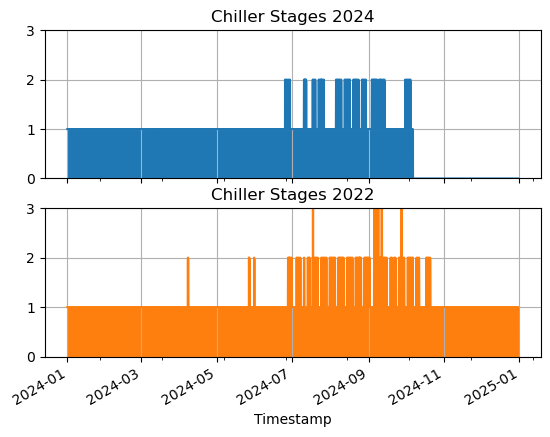

In [6]:
chiller_stage_cols = {
    2024: 'Chiller Stage 2024', 
    2022: 'Chiller Stage 2022'
}

fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, chiller_stage_cols.items()):
    df[col].plot.area(ax=ax, color=colors[year], ylim=[0, 3], 
                      grid=True, title=f"Chiller Stages {year}")

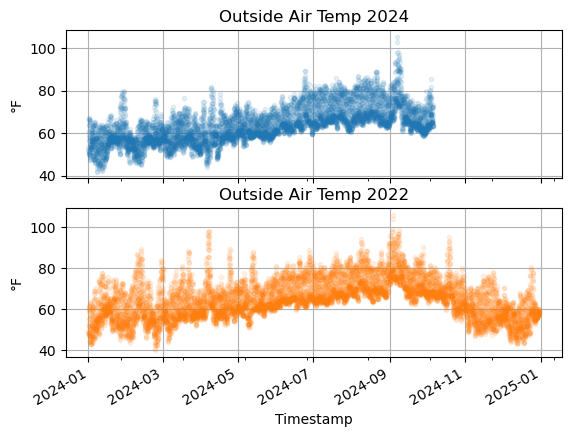

In [7]:
amb_air_temp_cols = {
    2024: "Outside Air Temp 2024",
    2022: "Outside Air Temp 2022"
}

fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, amb_air_temp_cols.items()):
    df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.1, 
                 ylabel=units[col], grid=True, title=col)

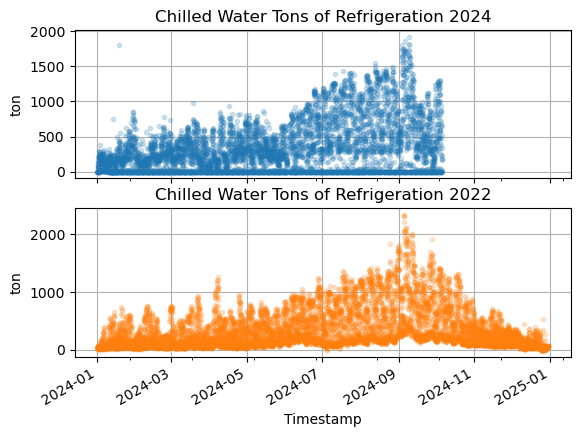

In [8]:
chilled_water_tons_cols = {
    2024: "Chilled Water Tons of Refrigeration 2024",
    2022: "Chilled Water Tons of Refrigeration 2022"
}

fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, chilled_water_tons_cols.items()):
    df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.2, 
                 ylabel=units[col], grid=True, title=col)

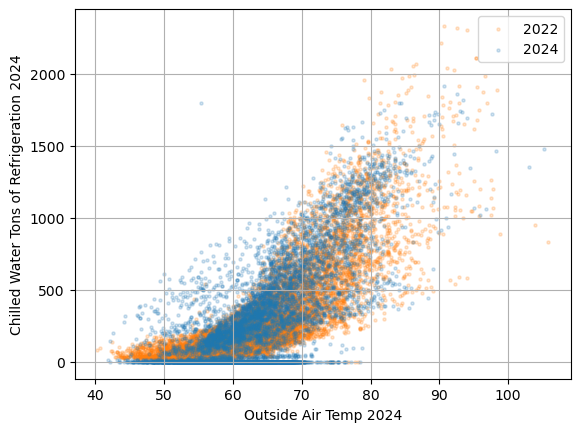

In [9]:
fig, ax = plt.subplots()
for year in reversed(amb_air_temp_cols.keys()):
    x_label = amb_air_temp_cols[year]
    y_label = chilled_water_tons_cols[year]
    df.plot.scatter(x=x_label, y=y_label, ax=ax, marker='.', 
                    color=colors[year], alpha=0.2, grid=True,
                    label=year)
plt.show()

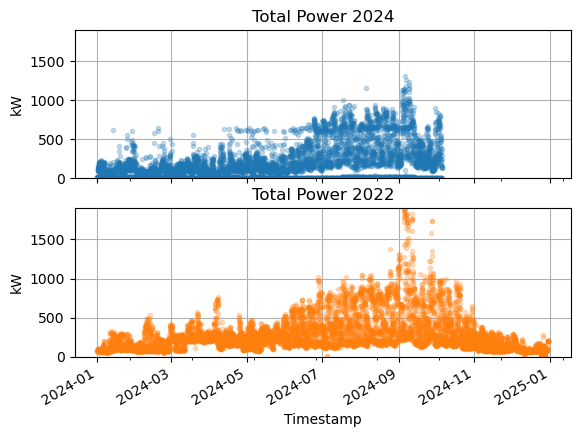

In [10]:
total_power_cols = {
    2024: "Total Power 2024",
    2022: "Total Power 2022"
}

max_power = max(df[col].max() for col in total_power_cols.values())

fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, total_power_cols.items()):
    df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.25, 
                 ylabel=units[col], ylim=[0, max_power], 
                 grid=True, title=col)

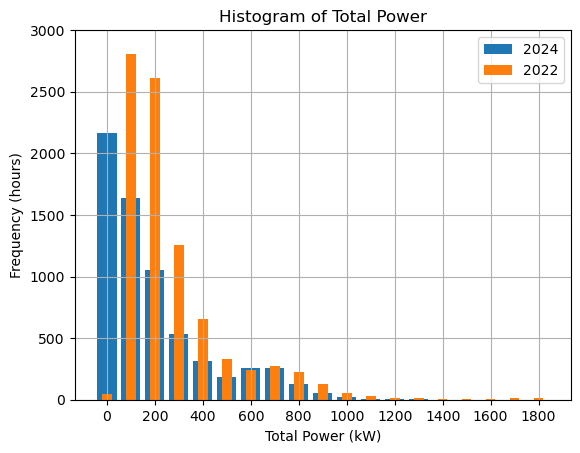

In [11]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()
bin_centers = np.linspace(0, 1900, 20)
bins = bin_centers - 50.0
for (year, col), bar_width in zip(total_power_cols.items(), [0.8, 0.4]):
    df[col].hist(ax=ax, bins=bins, histtype='barstacked', 
                 rwidth=bar_width, color=colors[year], label=year)
ax.set_xticks(bin_centers[::2])
ax.set_xticklabels(bin_centers[::2])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_ylim([0, 3000])
ax.set_xlabel(f'Total Power ({units[col]})')
ax.set_ylabel('Frequency (hours)')
ax.set_title("Histogram of Total Power")
ax.legend()
plt.show()

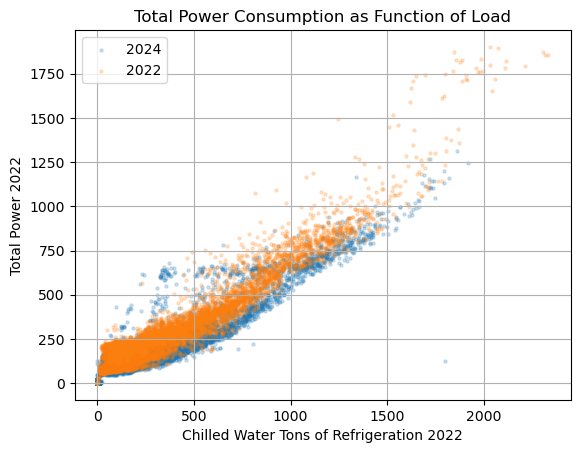

In [12]:
fig, ax = plt.subplots()
for year in chilled_water_tons_cols.keys():
    x_label = chilled_water_tons_cols[year]
    y_label = total_power_cols[year]
    df.plot.scatter(x=x_label, y=y_label, ax=ax, marker='.', 
                    color=colors[year], alpha=0.2, grid=True,
                    label=year)
plt.title('Total Power Consumption as Function of Load')
plt.show()

In [13]:
df['Hour of day'] = df.index.hour
df_by_hour_of_day = df.groupby('Hour of day').mean()
df_by_hour_of_day.head()

,Chiller 1 Efficiency 2024,Chiller 1 Efficiency 2022,Chiller 2 Efficiency 2024,Chiller 2 Efficiency 2022,Chiller 3 Efficiency 2024,Chiller 3 Efficiency 2022,Chilled Water Efficiency (C) 2024,Chilled Water Efficiency (C) 2022,Chilled Water Tons of Refrigeration 2024,Chilled Water Tons of Refrigeration 2022,Chiller Stage 2024,Chiller Stage 2022,Outside Air Temp 2024,Outside Air Temp 2022,Total Power 2024,Total Power 2022,Condenser Loop Wet Bulb Temp 2024,Condenser Loop Wet Bulb Temp 2022
Hour of day,,,,,,,,,,,,,,,,,,
0,0.000192,0.223737,0.002024,0.287876,0.001817,0.182107,0.006861,1.558936,1.276199,107.047400,1.000000,1.000000,60.148617,60.668745,11.469103,140.573044,55.861427,55.207112
1,0.005391,0.214635,0.000826,0.279573,0.005065,0.174941,0.016021,1.507165,21.141699,108.687805,1.000000,1.005464,59.759339,60.167623,29.800598,140.545348,55.640448,54.887658
2,0.008718,0.226175,0.003696,0.281589,0.009811,0.177728,0.030763,1.524249,35.577523,105.143564,1.000000,1.000000,59.432942,59.743435,51.799354,137.758966,55.461165,54.661578
3,0.025845,0.228645,0.007666,0.290970,0.015061,0.176688,0.061166,1.557638,87.261305,100.953021,1.003571,1.000000,59.095993,59.333905,90.884870,135.644559,55.257045,54.368320
4,0.038963,0.198316,0.005371,0.242150,0.021026,0.156949,0.084086,1.232230,107.310787,139.786562,1.007143,1.000000,58.867994,58.997154,112.217324,158.482815,55.075506,54.096893


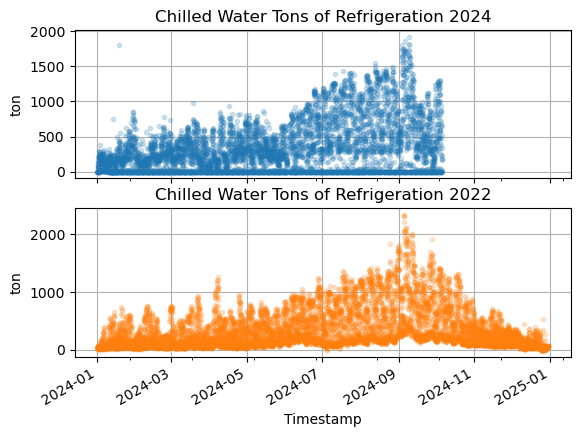

In [14]:
chilled_water_efficiency_cols = {
    2024: "Chilled Water Efficiency (C) 2024",
    2022: "Chilled Water Efficiency (C) 2022"
}

fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, chilled_water_tons_cols.items()):
    df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.2, 
                 ylabel=units[col], grid=True, title=col)

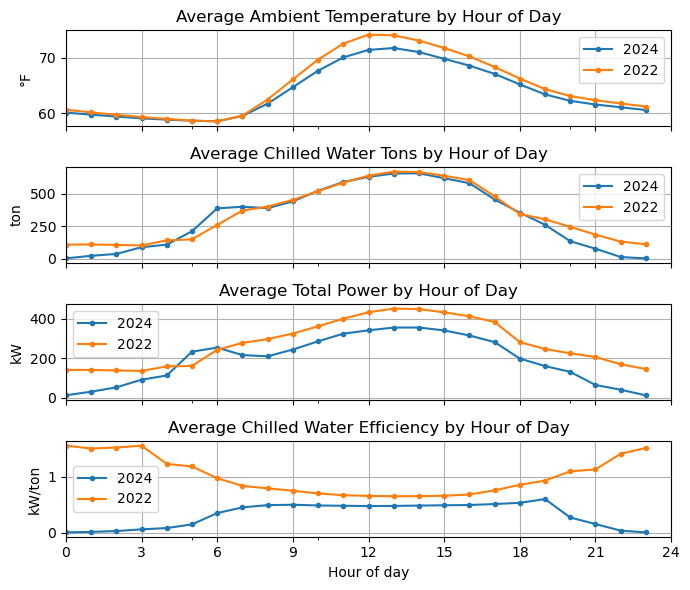

In [15]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(7, 6))
for year in total_power_cols.keys():

    col = amb_air_temp_cols[year]
    df_by_hour_of_day[col].plot(
        ax=axes[0], style='.-', color=colors[year], grid=True, 
        title='Average Ambient Temperature by Hour of Day', label=year,
        ylabel=units[col], legend=True
    )

    col = chilled_water_tons_cols[year]
    df_by_hour_of_day[col].plot(
        ax=axes[1], style='.-', color=colors[year], grid=True, 
        title='Average Chilled Water Tons by Hour of Day', label=year, 
        ylabel=units[col], legend=True
    )

    col = total_power_cols[year]
    df_by_hour_of_day[col].plot(
        ax=axes[2], style='.-', color=colors[year], grid=True, 
        title='Average Total Power by Hour of Day', label=year, 
        ylabel=units[col], legend=True
    )

    col = chilled_water_efficiency_cols[year]
    df_by_hour_of_day[col].plot(
        ax=axes[3], style='.-', color=colors[year], grid=True, 
        title='Average Chilled Water Efficiency by Hour of Day', label=year, 
        ylabel=units[col], legend=True
    )

for ax in axes:
    ax.set_xticks(list(range(0, 25, 3)))
    ax.set_xlim([0, 24])
plt.tight_layout()
filename = "averages_by_hour_of_day.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

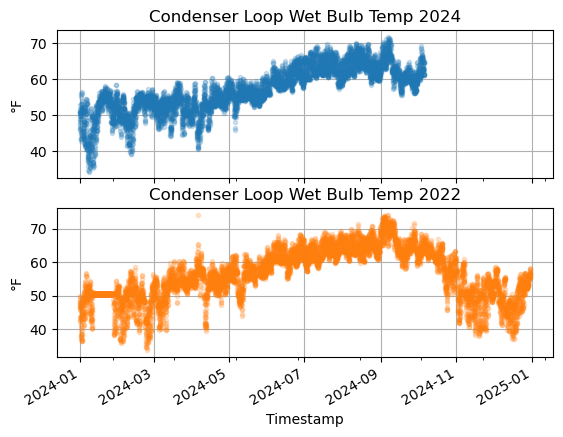

In [16]:
condenser_loop_wbt_cols = {
    2024: 'Condenser Loop Wet Bulb Temp 2024',
    2022: 'Condenser Loop Wet Bulb Temp 2022'
}

fig, axes = plt.subplots(2, 1, sharex=True)
for ax, (year, col) in zip(axes, condenser_loop_wbt_cols.items()):
    df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.2, 
                 ylabel=units[col], grid=True, title=col)

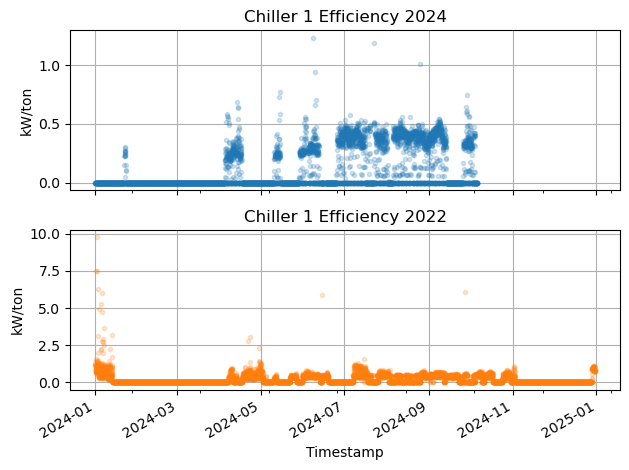

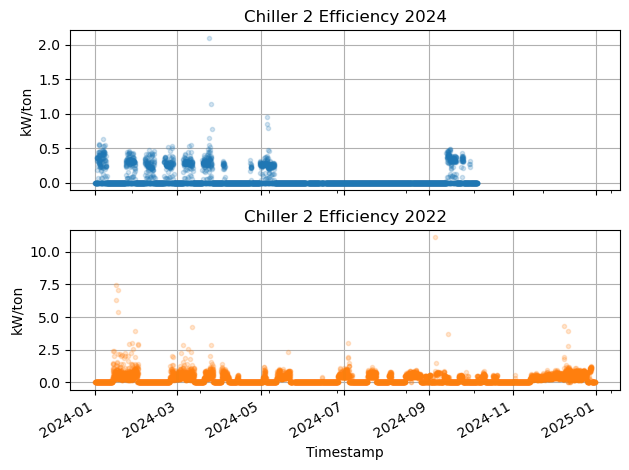

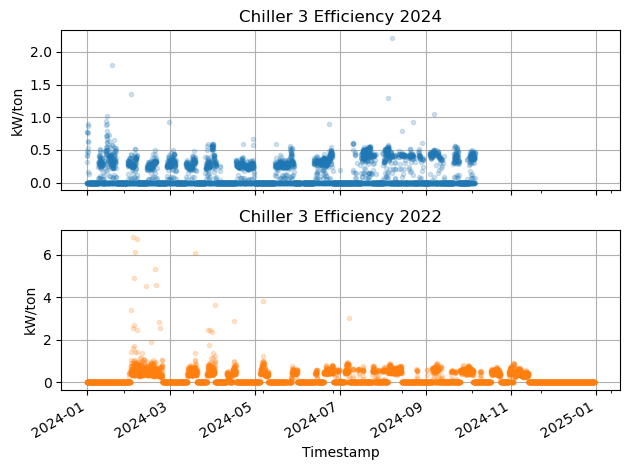

In [17]:
chiller_efficiency_cols = {
    1: {
        2024: "Chiller 1 Efficiency 2024",
        2022: "Chiller 1 Efficiency 2022"
    },
    2: {
        2024: "Chiller 2 Efficiency 2024",
        2022: "Chiller 2 Efficiency 2022"
    },
    3: {
        2024: "Chiller 3 Efficiency 2024",
        2022: "Chiller 3 Efficiency 2022"
    }
}

for chiller in chiller_efficiency_cols:
    fig, axes = plt.subplots(2, 1, sharex=True)
    for ax, (year, col) in zip(axes, chiller_efficiency_cols[chiller].items()):
        df[col].plot(ax=ax, style='.', color=colors[year], alpha=0.2, 
                     ylabel=units[col], grid=True, title=col)
    plt.tight_layout()
    plt.show()

In [18]:
# Chiller efficiency data may be a proxy for 'chiller is operating'
df["Chiller 1 Efficiency 2024"].value_counts().iloc[:10]

Chiller 1 Efficiency 2024
0.000000    4751
0.287068       1
0.420550       1
0.376342       1
0.359971       1
0.372179       1
0.415343       1
0.405952       1
0.394699       1
0.393855       1
Name: count, dtype: int64

In [19]:
df["Chiller 3 Efficiency 2022"].value_counts().iloc[:10]

Chiller 3 Efficiency 2022
0.000000    6006
0.548886       1
0.500768       1
0.521416       1
0.506394       1
0.521970       1
0.539509       1
0.549272       1
0.509508       1
0.527557       1
Name: count, dtype: int64

In [20]:
# Assume efficiency equal to 0 means chiller is offline
chiller_operating_cols = {}
for chiller in chiller_efficiency_cols:
    operating_cols = {}
    for (year, col) in chiller_efficiency_cols[chiller].items():
        new_col_name = col.replace("Efficiency", "Operating Status")
        df[new_col_name] = df[col] > 0.0
        units[new_col_name] = "0 or 1"
        operating_cols[year] = new_col_name
    chiller_operating_cols[chiller] = operating_cols

chiller_operating_cols

{1: {2024: 'Chiller 1 Operating Status 2024',
  2022: 'Chiller 1 Operating Status 2022'},
 2: {2024: 'Chiller 2 Operating Status 2024',
  2022: 'Chiller 2 Operating Status 2022'},
 3: {2024: 'Chiller 3 Operating Status 2024',
  2022: 'Chiller 3 Operating Status 2022'}}

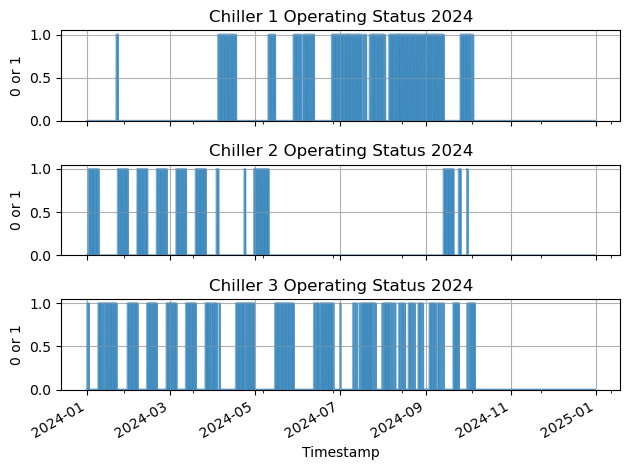

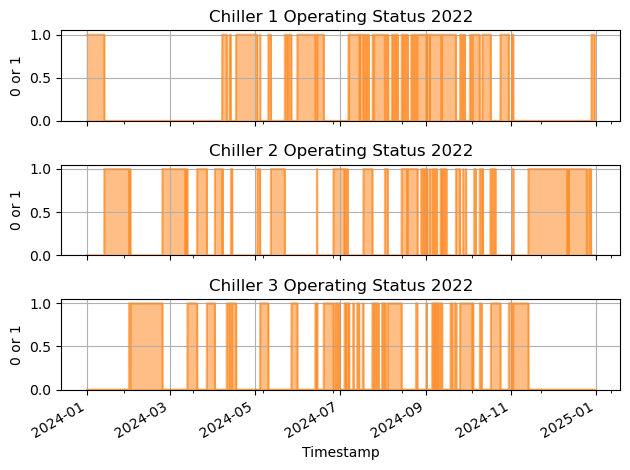

In [21]:
for year in chiller_operating_cols[1]:
    fig, axes = plt.subplots(3, 1, sharex=True)
    for ax, chiller in zip(axes, chiller_operating_cols):
        col = chiller_operating_cols[chiller][year]
        df[col].astype("uint8").plot.area(ax=ax, color=colors[year], alpha=0.5, 
                     ylabel=units[col], grid=True, title=col)
    plt.tight_layout()
    plt.show()

In [22]:
# Compute number of chillers operating
for year in chiller_operating_cols[1]:
    cols = [chiller_operating_cols[chiller][year] for chiller in chiller_operating_cols]
    new_col = f"Number of Chillers Operating {year}"
    df[new_col] = df[cols].sum(axis=1)
    units[new_col] = 'Count'

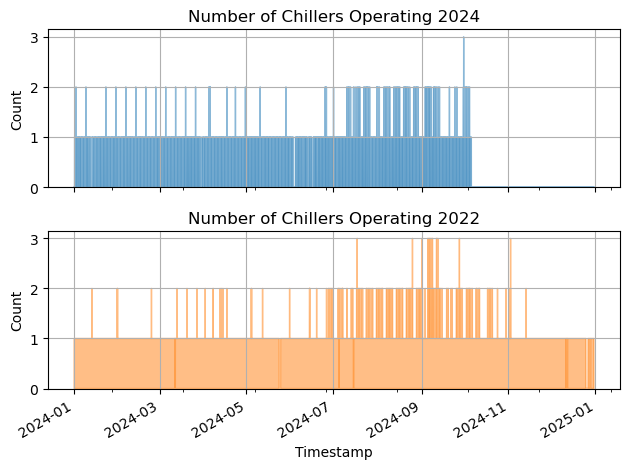

In [23]:
fig, axes = plt.subplots(2, 1, sharex=True)
for ax, year in zip(axes, chiller_operating_cols[1]):
    col = f"Number of Chillers Operating {year}"
    df[col].plot.area(ax=ax, color=colors[year], linestyle='', alpha=0.5,
                      ylabel=units[col], grid=True, title=col)
plt.tight_layout()
plt.show()

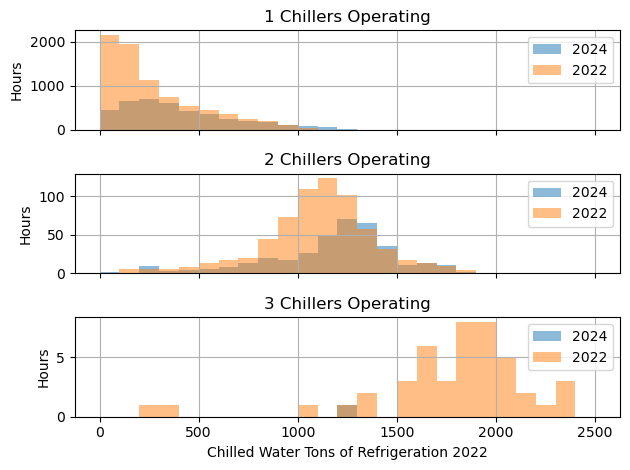

In [24]:
fig, axes = plt.subplots(3, 1, sharex=True)

for number_of_chillers, ax in zip([1, 2, 3], axes):
    for year in [2024, 2022]:
        selected_times = df[f"Number of Chillers Operating {year}"] == number_of_chillers
        bins = np.linspace(0, 2500, 26)
        x_label = chilled_water_tons_cols[year]
        df.loc[selected_times, x_label].hist(ax=ax, alpha=0.5, bins=bins, label=year)
            # df.plot.scatter(x=x_label, y=y_label, ax=ax, marker='o', 
            #                 color=colors[year], alpha=0.2, grid=True,
            #                 label=year)
        ax.set_ylabel('Hours')
        ax.set_title(f'{number_of_chillers} Chillers Operating')
        ax.legend()
axes[-1].set_xlabel(x_label)
plt.tight_layout()
plt.show()

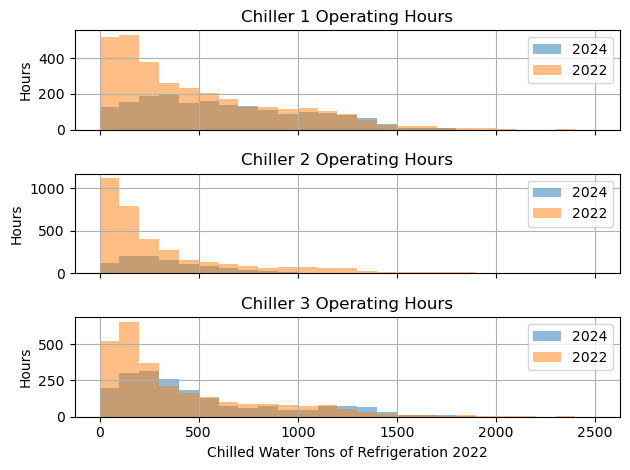

In [25]:
fig, axes = plt.subplots(3, 1, sharex=True)

for chiller, ax in zip([1, 2, 3], axes):
    for year in [2024, 2022]:
        selected_times = df[f"Chiller {chiller} Operating Status {year}"]
        bins = np.linspace(0, 2500, 26)
        x_label = chilled_water_tons_cols[year]
        df.loc[selected_times, x_label].hist(ax=ax, alpha=0.5, bins=bins, label=year)
            # df.plot.scatter(x=x_label, y=y_label, ax=ax, marker='o', 
            #                 color=colors[year], alpha=0.2, grid=True,
            #                 label=year)
        ax.set_ylabel('Hours')
        ax.set_title(f'Chiller {chiller} Operating Hours')
        ax.legend()
axes[-1].set_xlabel(x_label)
plt.tight_layout()
plt.show()

In [26]:
hours_of_data_by_year = {year: (~df[f"Total Power {year}"].isna()).sum() for year in [2022, 2024]}
hours_of_data_by_year

{2022: 8735, 2024: 6620}

In [27]:
# Note 2024 is not a complete year so should average by day
years = [2022, 2024]
chillers_operating_hours = pd.concat(
    [df[f"Number of Chillers Operating {year}"].value_counts() for year in years], 
    axis=1, 
    keys=years
)
chillers_operating_summary = chillers_operating_hours.drop(0).T
chillers_operating_summary.index.name = 'Number of chillers operating'
chillers_operating_summary['Total'] = chillers_operating_summary.sum(axis=1)
chillers_operating_summary = chillers_operating_summary.T

chillers_operating_summary_daily_avg = pd.DataFrame(index=chillers_operating_summary.index)
for year in years:
    chillers_operating_summary_daily_avg[year] = (chillers_operating_summary[year] * 24 / hours_of_data_by_year[year]).round(1)
chillers_operating_summary = pd.concat([chillers_operating_summary, chillers_operating_summary_daily_avg], axis=1, keys=['Hours', 'Avg. Hours Per Day'])
chillers_operating_summary

Hours       Avg. Hours Per Day      
Number of chillers operating  2022  2024               2022  2024
1                             7981  4124               21.9  15.0
2                              659   367                1.8   1.3
3                               45     1                0.1   0.0
Total                         8685  4492               23.9  16.3

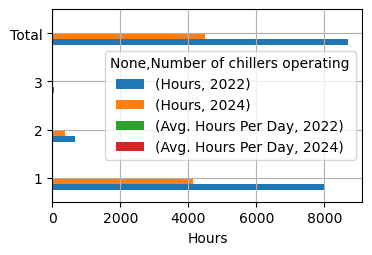

In [28]:
chillers_operating_summary.plot.barh(grid=True, figsize=(4, 2.5), xlabel='Hours')
plt.show()

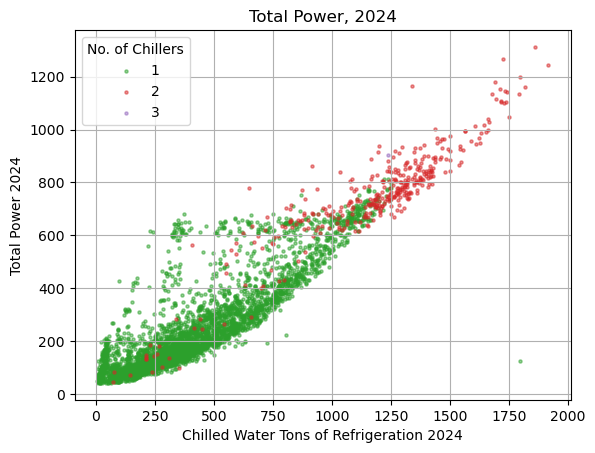

In [29]:
fig, ax = plt.subplots()
year = 2024
colors2 = ["tab:green", "tab:red", "tab:purple"]
for number_of_chillers in [1, 2, 3]:
    times_when_1_chiller_operating = df[f"Number of Chillers Operating {year}"] == number_of_chillers
    x_label = chilled_water_tons_cols[year]
    y_label = total_power_cols[year]
    data = df.loc[times_when_1_chiller_operating]
    data.plot.scatter(x=x_label, y=y_label, ax=ax, marker='.', 
                      color=colors2[number_of_chillers - 1], alpha=0.5, grid=True,
                      label=number_of_chillers)
plt.title(f"Total Power, {year}")
plt.legend(title="No. of Chillers")
plt.show()

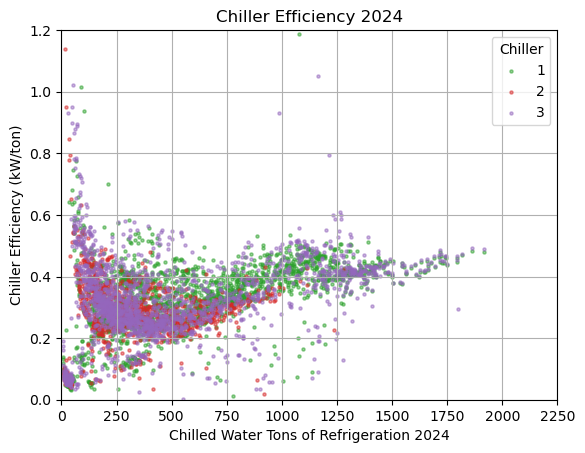

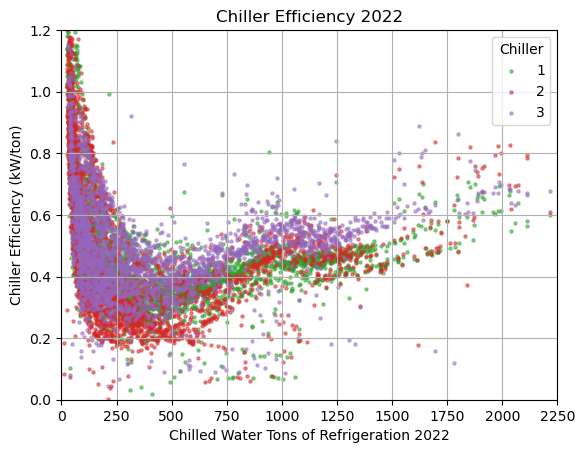

In [30]:
for year in chiller_efficiency_cols[1]:
    fig, ax = plt.subplots()
    colors2 = ["tab:green", "tab:red", "tab:purple"]
    for chiller in chiller_efficiency_cols:
        times_chiller_operating = df[f"Chiller {chiller} Operating Status {year}"]
        x_label = chilled_water_tons_cols[year]
        y_label = chiller_efficiency_cols[chiller][year]
        data = df.loc[times_chiller_operating]
        data.plot.scatter(x=x_label, y=y_label, ax=ax, marker='.', 
                          color=colors2[chiller-1], alpha=0.5, grid=True,
                          ylabel=f"Chiller Efficiency ({units[y_label]})",label=chiller)
    plt.xlim([0., 2250.0])
    plt.ylim([0, 1.2])
    plt.title(f"Chiller Efficiency {year}")
    plt.legend(title="Chiller")
    plt.show()

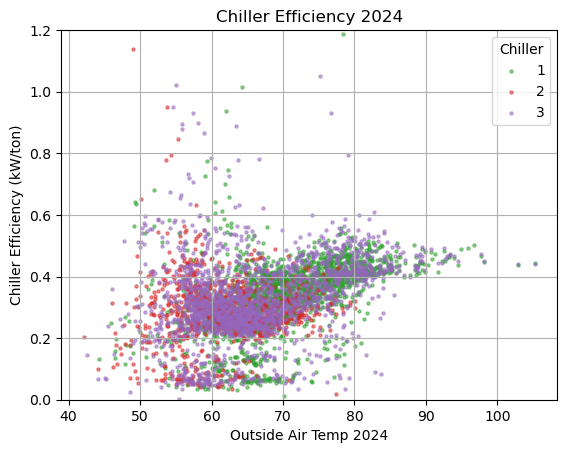

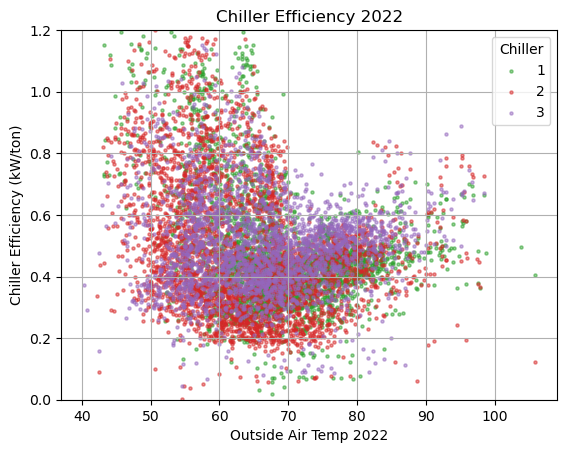

In [31]:
for year in chiller_efficiency_cols[1]:
    fig, ax = plt.subplots()
    colors2 = ["tab:green", "tab:red", "tab:purple"]
    for chiller in chiller_efficiency_cols:
        times_chiller_operating = df[f"Chiller {chiller} Operating Status {year}"]
        x_label = amb_air_temp_cols[year]
        y_label = chiller_efficiency_cols[chiller][year]
        data = df.loc[times_chiller_operating]
        data.plot.scatter(x=x_label, y=y_label, ax=ax, marker='.', 
                          color=colors2[chiller-1], alpha=0.5, grid=True,
                          ylabel=f"Chiller Efficiency ({units[y_label]})",label=chiller)
    plt.ylim([0, 1.2])
    plt.title(f"Chiller Efficiency {year}")
    plt.legend(title="Chiller")
    plt.show()

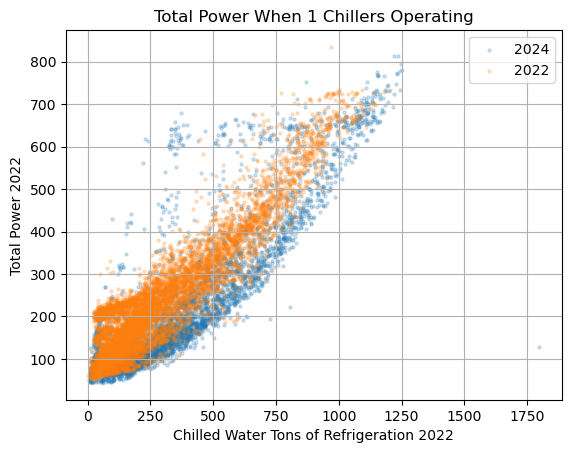

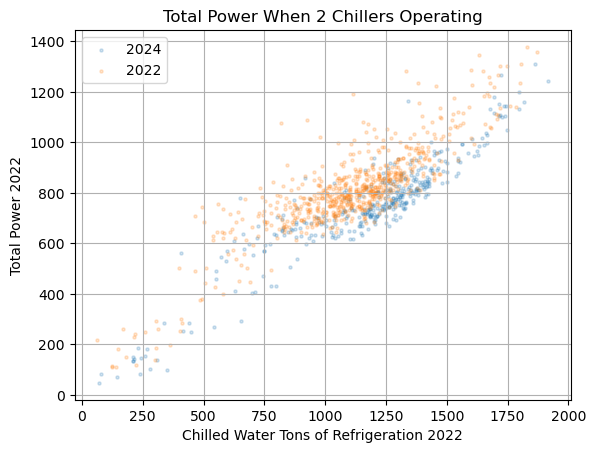

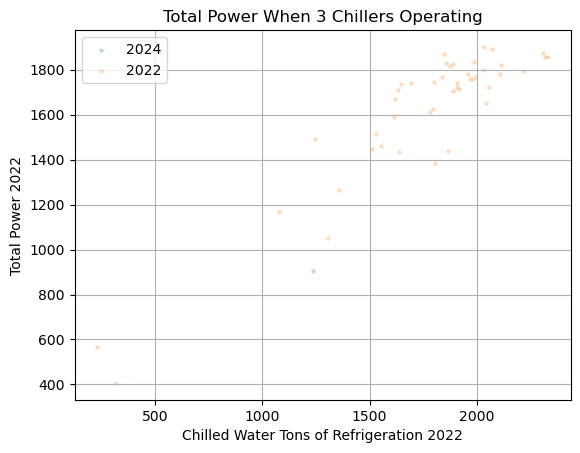

In [32]:
for number_of_chillers in [1, 2, 3]:
    fig, ax = plt.subplots()
    for year in chilled_water_tons_cols.keys():
        selected_times = df[f"Number of Chillers Operating {year}"] == number_of_chillers
        x_label = chilled_water_tons_cols[year]
        y_label = total_power_cols[year]
        data = df.loc[selected_times]
        data.plot.scatter(x=x_label, y=y_label, ax=ax, marker='.', 
                          color=colors[year], alpha=0.2, grid=True,
                          label=year)
    plt.title(f"Total Power When {number_of_chillers} Chillers Operating")
    plt.show()

## Save complete data to CSV file

In [33]:
filename = 'prepared-data-hourly.csv'
df.to_csv(os.path.join(data_dir, filename))
print(f"Data saved to {filename}")

Data saved to prepared-data-hourly.csv
